# Thought here - feb 23

- what if we train our model with respect to each class one after another one
- this is called **transfer learning**
- we might need to mix some data points of previous attack type to the new attack type, so that the model does not completely forget
about the previous attack and learn completely the new attack, this is called catastrophic forgetting



In [2]:
import pandas as pd

In [8]:
malware = pd.read_csv('smote_malware.csv')
ddos = pd.read_csv('smote_ddos.csv')
intrusion = pd.read_csv('smote_intrusion.csv')

In [10]:
malware = malware.drop('device_os', axis=1)
ddos = ddos.drop('device_os', axis=1)
intrusion = intrusion.drop('device_os', axis=1)

In [17]:
malware.head()

,protocol,packet_length,packet_type,traffic_type,malware_indicators,anomaly_scores,alerts_warnings,attack_signature,action_taken,network_segment,log_source,hour,day,week_day,month,browser,severity_encoded,target
0,UDP,332,1,DNS,1,29,0,Known Pattern B,Blocked,Segment A,1,21,8,1,11,Mozilla,2,Malware
1,UDP,1366,1,HTTP,1,88,0,Known Pattern B,Logged,Segment A,1,19,17,5,7,Mozilla,2,Malware
2,TCP,648,1,HTTP,1,27,1,Known Pattern A,Blocked,Segment C,1,3,20,1,7,Mozilla,1,Malware
3,TCP,1366,1,DNS,0,83,1,Known Pattern A,Blocked,Segment C,1,16,21,1,7,Mozilla,0,Malware
4,ICMP,516,1,HTTP,0,77,0,Known Pattern A,Ignored,Segment A,1,23,25,6,4,Mozilla,0,Malware


# We use SGD

```python
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle

# ===== LOAD DATA =====
df_attack_A = pd.read_csv('attack_A.csv')
df_attack_B = pd.read_csv('attack_B.csv')

X_attack_A = df_attack_A.drop(columns=['attack_type'])
y_attack_A = df_attack_A['attack_type']

X_attack_B = df_attack_B.drop(columns=['attack_type'])
y_attack_B = df_attack_B['attack_type']

# ===== ENCODE TARGET: FIT ON ALL CLASSES =====
y_combined = np.concatenate([y_attack_A, y_attack_B])
le = LabelEncoder()
le.fit(y_combined)  # Fit once on all unique classes

# Transform each dataset
y_attack_A_encoded = le.transform(y_attack_A)
y_attack_B_encoded = le.transform(y_attack_B)

print("All attack classes:", le.classes_)
print("Number of classes:", len(le.classes_))

# Save encoder
pickle.dump(le, open('label_encoder.pkl', 'wb'))

# ===== SPLIT DATA =====
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(
    X_attack_A, y_attack_A_encoded, test_size=0.2, 
    random_state=42, stratify=y_attack_A_encoded
)

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_attack_B, y_attack_B_encoded, test_size=0.2, 
    random_state=42, stratify=y_attack_B_encoded
)

# ===== CREATE PREPROCESSOR =====
categorical_cols = ['protocol', 'method']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# ===== CREATE MODEL =====
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(warm_start=True, loss='log_loss'))
])

# ===== TRAIN PHASE 1: Attack A =====
model.fit(X_train_A, y_train_A)
print("\n=== After Training on Attack A ===")
print("Train accuracy:", model.score(X_train_A, y_train_A))
print("Test accuracy:", model.score(X_test_A, y_test_A))

# ===== TRAIN PHASE 2: Mixed A + B =====
X_train_mixed = pd.concat([X_train_A, X_train_B], ignore_index=True)
y_train_mixed = np.concatenate([y_train_A, y_train_B])

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_train_mixed),
    y_train_mixed,
    classes=np.unique(y_combined)  # Include all classes
)

print("\n=== After Training on Attack A + B ===")
print("Attack A test accuracy:", model.score(X_test_A, y_test_A))
print("Attack B test accuracy:", model.score(X_test_B, y_test_B))

# ===== MAKE PREDICTIONS =====
y_pred_B = model.predict(X_test_B)
y_pred_text = le.inverse_transform(y_pred_B)
print("\nSample predictions:", y_pred_text[:5])
'''

## label encoding

In [14]:
# load and preprocess data
cat_cols = malware.select_dtypes('object').columns.to_list()

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np

In [18]:
malware_x = malware.drop('target', axis=1)
malware_y = malware['target']

ddos_x = ddos.drop('target', axis=1)
ddos_y = ddos['target']

intrusion_x = intrusion.drop('target', axis=1)
intrusion_y = intrusion['target']

# encode all target - fit all classes
y_combined = np.concatenate([malware_y, ddos_y, intrusion_y])

# label encoder
le = LabelEncoder()
le.fit(y_combined) # fit for all classes

LabelEncoder()

In [23]:
print("All attack classes:", le.classes_)
print("Number of classes:", len(le.classes_))

All attack classes: ['DDoS' 'Intrusion' 'Malware']
Number of classes: 3


In [24]:
# transform each dataset
malware_y_encoded = le.transform(malware_y)
ddos_y_encoded = le.transform(ddos_y)
intrusion_y_encoded = le.transform(intrusion_y)

In [27]:
# save the label encoder
pickle.dump(le, open('label_encoder.pkl', 'wb'))

## split data

In [28]:
X_train_malware, X_test_malware, y_train_malware, y_test_malware = train_test_split(
    malware_x, malware_y_encoded, test_size=0.2, random_state=42, stratify=malware_y_encoded
)

X_train_ddos, X_test_ddos, y_train_ddos, y_test_ddos = train_test_split(
    ddos_x, ddos_y_encoded, test_size=0.2, random_state=42, stratify=ddos_y_encoded
)

X_train_intrusion, X_test_intrusion, y_train_intrusion, y_test_intrusion = train_test_split(
    intrusion_x, intrusion_y_encoded, test_size=0.2, random_state=42, stratify=intrusion_y_encoded
)

In [39]:
print("Intrusion: ", X_train_intrusion.shape, X_test_intrusion.shape)

Intrusion:  (1280, 17) (320, 17)


## create processor

In [48]:
cat_cols = X_train_intrusion.select_dtypes('object').columns.to_list()
num_cols = ['packet_length', 'anomaly_scores']

# preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

## Create Model

In [80]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(warm_start=True, loss='log_loss', max_iter=500))
])

### training phase 1

In [81]:
dummy_size = 50
X_phase1 = pd.concat([X_train_malware, X_train_ddos.iloc[:dummy_size]], ignore_index=True)
y_phase1 = np.concatenate([y_train_malware, y_train_ddos[:dummy_size]])

# Use partial_fit instead of fit() and specify all 3 classes
model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase1),
    y_phase1,
    classes=np.array([0, 1, 2])  # All 3 classes from the start
)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'log_loss'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",500
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [82]:
print("Attack A test accuracy:", model.score(X_test_malware, y_test_malware))
print("Attack B test accuracy:", model.score(X_test_ddos, y_test_ddos))

Attack A test accuracy: 1.0
Attack B test accuracy: 0.0


In [83]:
# Save checkpoint after Phase 1
pickle.dump(model, open('model_phase1.pkl', 'wb'))

### training phase 2

In [84]:
X_train_mixed = pd.concat([
    X_train_malware,
    X_train_ddos.iloc[dummy_size:]
], ignore_index=True)

y_train_mixed = pd.concat([
    pd.Series(y_train_malware),
    pd.Series(y_train_ddos[dummy_size:])
], ignore_index=True)

# use partial weights
# Use partial_fit to continue from Phase 1 weights
model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_train_mixed),
    y_train_mixed,
    classes=np.array([0, 1, 2])
)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'log_loss'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",500
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [85]:
print("Attack A test accuracy:", model.score(X_test_malware, y_test_malware))
print(f"Attack B test accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")


Attack A test accuracy: 0.35625
Attack B test accuracy: 0.3375


In [86]:
# Save checkpoint after Phase 2
pickle.dump(model, open('model_phase2.pkl', 'wb'))

### training phase 3

In [87]:
X_train_mixed_3 = pd.concat([
    X_train_ddos,
    X_train_intrusion.iloc[dummy_size:]
], ignore_index=True)

y_train_mixed_3 = pd.concat([
    pd.Series(y_train_ddos),
    pd.Series(y_train_intrusion[dummy_size:])
], ignore_index=True)

# use partial weights
# Use partial_fit to continue from Phase 1 weights
model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_train_mixed_3),
    y_train_mixed_3,
    classes=np.array([0, 1, 2])
)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'log_loss'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",500
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [88]:
print(f"Attack B test accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Attack B test accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")

Attack B test accuracy: 0.1906
Attack B test accuracy: 0.9219


## Testing part

In [89]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [90]:
le = pickle.load(open('label_encoder.pkl', 'rb'))

X_test_combined = pd.concat([
    X_test_malware,
    X_test_ddos,
    X_test_intrusion
], ignore_index=True)

y_test_combined = np.concatenate([
    y_test_malware,
    y_test_ddos,
    y_test_intrusion
])

y_pred_combined = model.predict(X_test_combined)

In [91]:
# ===== OVERALL ACCURACY =====
overall_accuracy = accuracy_score(y_test_combined, y_pred_combined)
print("=== COMBINED TEST SET EVALUATION ===")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# ===== DETAILED CLASSIFICATION REPORT =====
print("\n=== Classification Report ===")
print(classification_report(
    y_test_combined, 
    y_pred_combined,
    target_names=le.classes_
))


=== COMBINED TEST SET EVALUATION ===
Overall Accuracy: 0.3708

=== Classification Report ===
              precision    recall  f1-score   support

        DDoS       0.52      0.19      0.28       320
   Intrusion       0.35      0.92      0.51       320
     Malware       0.00      0.00      0.00       320

    accuracy                           0.37       960
   macro avg       0.29      0.37      0.26       960
weighted avg       0.29      0.37      0.26       960



/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/saiadityalakkum/miniconda3/envs/ml_cyber/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

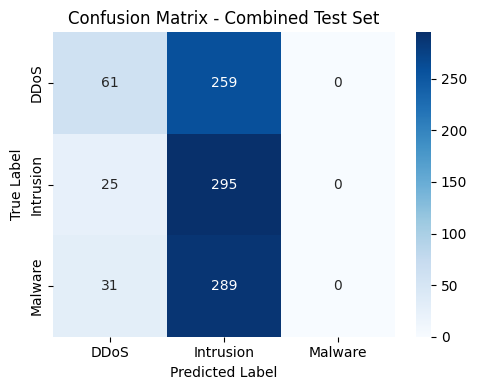

In [95]:
import seaborn as sns
# ===== CONFUSION MATRIX =====
cm = confusion_matrix(y_test_combined, y_pred_combined)

# ===== VISUALIZE CONFUSION MATRIX =====
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix - Combined Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [96]:
# ===== PER-CLASS ACCURACY =====
print("\n=== Per-Class Accuracy ===")
print(f"Malware accuracy: {model.score(X_test_malware, y_test_malware):.4f}")
print(f"DDoS accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Intrusion accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")


=== Per-Class Accuracy ===
Malware accuracy: 0.0000
DDoS accuracy: 0.1906
Intrusion accuracy: 0.9219


## Create model part 2

In [156]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(warm_start=True, loss='log_loss', max_iter=500))
])

### phase 1

In [169]:
from sklearn.utils import shuffle

# Define dummy sizes
dummy_size_ddos = 200
dummy_size_intrusion = 100

# ===== PHASE 1: Malware + Dummy DDoS + Dummy Intrusion =====
print("=== PHASE 1: Malware + Dummy DDoS + Dummy Intrusion ===")
X_phase1 = pd.concat([
    X_train_malware,
    X_train_ddos.iloc[:dummy_size_ddos],
    X_train_intrusion.iloc[:dummy_size_intrusion]
], ignore_index=True)

y_phase1 = np.concatenate([
    y_train_malware,
    y_train_ddos[:dummy_size_ddos],
    y_train_intrusion[:dummy_size_intrusion]
])

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase1),
    y_phase1,
    classes=np.array([0, 1, 2])
)

print(f"Malware accuracy: {model.score(X_test_malware, y_test_malware):.4f}")
print(f"DDoS accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Intrusion accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")

=== PHASE 1: Malware + Dummy DDoS + Dummy Intrusion ===
Malware accuracy: 0.9812
DDoS accuracy: 0.0156
Intrusion accuracy: 0.0938


### phase 2

In [170]:
print("\n=== PHASE 2: Full Malware + Full DDoS + Dummy Intrusion ===")
X_phase2 = pd.concat([
    X_train_malware,
    X_train_ddos.iloc[dummy_size_ddos:],  # Remaining DDoS
    X_train_intrusion.iloc[:dummy_size_intrusion]  # Same dummy Intrusion
], ignore_index=True)

y_phase2 = np.concatenate([
    y_train_malware,
    y_train_ddos[dummy_size_ddos:],
    y_train_intrusion[:dummy_size_intrusion]
])

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase2),
    y_phase2,
    classes=np.array([0, 1, 2])
)

print(f"Malware accuracy: {model.score(X_test_malware, y_test_malware):.4f}")
print(f"DDoS accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Intrusion accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")



=== PHASE 2: Full Malware + Full DDoS + Dummy Intrusion ===
Malware accuracy: 0.9094
DDoS accuracy: 0.1969
Intrusion accuracy: 0.0281


### phase 3

In [171]:
print("\n=== PHASE 3: Full Malware + Full DDoS + Full Intrusion ===")
X_phase3 = pd.concat([
    X_train_malware,
    X_train_ddos.iloc[dummy_size_ddos:],
    X_train_intrusion.iloc[dummy_size_intrusion:]  # Remaining Intrusion
], ignore_index=True)

y_phase3 = np.concatenate([
    y_train_malware,
    y_train_ddos[dummy_size_ddos:],
    y_train_intrusion[dummy_size_intrusion:]
])

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase3),
    y_phase3,
    classes=np.array([0, 1, 2])
)

print(f"Malware accuracy: {model.score(X_test_malware, y_test_malware):.4f}")
print(f"DDoS accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Intrusion accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")


=== PHASE 3: Full Malware + Full DDoS + Full Intrusion ===
Malware accuracy: 0.4844
DDoS accuracy: 0.6219
Intrusion accuracy: 0.3344


In [172]:
print("\n=== COMBINED TEST SET ===")
X_test_combined = pd.concat([X_test_malware, X_test_ddos, X_test_intrusion], ignore_index=True)
y_test_combined = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])

y_pred_combined = model.predict(X_test_combined)
overall_accuracy = np.mean(y_pred_combined == y_test_combined)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Malware accuracy: {model.score(X_test_malware, y_test_malware):.4f}")
print(f"DDoS accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Intrusion accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")


=== COMBINED TEST SET ===
Overall Accuracy: 0.4802
Malware accuracy: 0.4844
DDoS accuracy: 0.6219
Intrusion accuracy: 0.3344


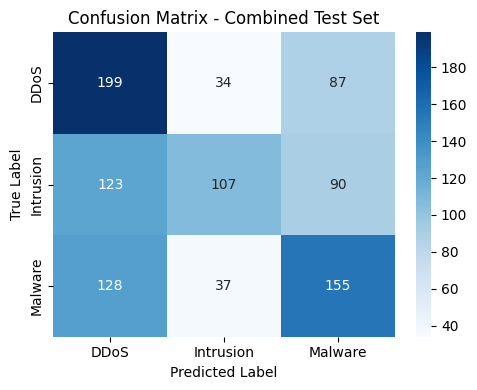

In [173]:
import seaborn as sns
# ===== CONFUSION MATRIX =====
cm = confusion_matrix(y_test_combined, y_pred_combined)

# ===== VISUALIZE CONFUSION MATRIX =====
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix - Combined Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [174]:
# Save checkpoint after Phase 2
pickle.dump(model, open('test/test3/model_test_2.pkl', 'wb'))

=== MLP CLASSIFIER WITH INCREMENTAL LEARNING ===

=== PHASE 1: Focus on Malware ===
Training data distribution:
  Malware: 896
  DDoS: 268
  Intrusion: 134

Malware: 0.9844 | DDoS: 0.0437 | Intrusion: 0.0281

=== PHASE 2: Add DDoS Data ===
Training data distribution:
  Malware: 896
  DDoS: 627
  Intrusion: 179

Malware: 0.5563 | DDoS: 0.7000 | Intrusion: 0.0406

=== PHASE 3: Add Intrusion Data ===
Training data distribution:
  Malware: 896
  DDoS: 896
  Intrusion: 896

Malware: 0.3187 | DDoS: 0.7375 | Intrusion: 0.4125

=== COMBINED TEST SET ===
Overall Accuracy: 0.4896
Malware accuracy: 0.3187
DDoS accuracy: 0.7375
Intrusion accuracy: 0.4125

=== Classification Report ===
              precision    recall  f1-score   support

        DDoS       0.43      0.74      0.54       320
   Intrusion       0.60      0.41      0.49       320
     Malware       0.55      0.32      0.40       320

    accuracy                           0.49       960
   macro avg       0.52      0.49      0.48   

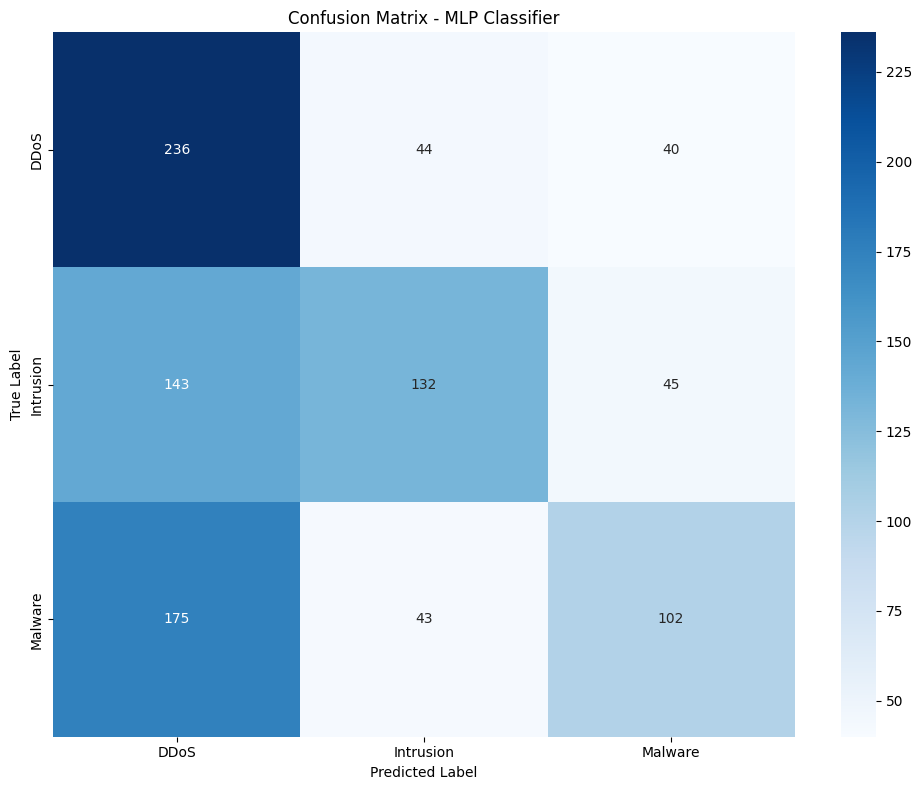

In [200]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle

# ===== ENCODE TARGET =====
# y_combined = np.concatenate([y_train_malware, y_train_ddos, y_train_intrusion])
# le = LabelEncoder()
# le.fit(y_combined)

# y_train_malware_encoded = le.transform(y_train_malware)
# y_train_ddos_encoded = le.transform(y_train_ddos)
# y_train_intrusion_encoded = le.transform(y_train_intrusion)

# y_test_malware_encoded = le.transform(y_test_malware)
# y_test_ddos_encoded = le.transform(y_test_ddos)
# y_test_intrusion_encoded = le.transform(y_test_intrusion)

# print("All attack classes:", le.classes_)
# pickle.dump(le, open('label_encoder_mlp.pkl', 'wb'))

# # ===== CREATE PREPROCESSOR =====
# numerical_cols = ['duration', 'bytes_sent']
# categorical_cols = ['protocol', 'method']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_cols),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
#     ]
# )

# ===== CREATE MLP MODEL =====
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(64),  # 3 hidden layers
        activation='relu',                  # ReLU activation function
        solver='adam',                      # Adam optimizer (good for neural networks)
        learning_rate_init=0.01,           # Initial learning rate
        max_iter=1000,                       # Max iterations per partial_fit call
        warm_start=True,                    # Enable incremental learning
        # early_stopping=True,                # Stop early if validation score plateaus
        # validation_fraction=0.1,            # Use 10% for validation
        # n_iter_no_change=10,                # Stop if no improvement for 10 iterations
        random_state=42,
        # verbose=True
    ))
])

print("=== MLP CLASSIFIER WITH INCREMENTAL LEARNING ===\n")

# Define split sizes
split_malware = int(len(X_train_malware) * 0.7)
split_ddos = int(len(X_train_ddos) * 0.7)
split_intrusion = int(len(X_train_intrusion) * 0.7)

# ===== PHASE 1: Focus on Malware =====
print("=== PHASE 1: Focus on Malware ===")
X_phase1 = pd.concat([
    X_train_malware.iloc[:split_malware],
    X_train_ddos.iloc[:int(split_ddos * 0.3)],
    X_train_intrusion.iloc[:int(split_intrusion * 0.15)]
], ignore_index=True)

y_phase1 = np.concatenate([
    y_train_malware[:split_malware],
    y_train_ddos[:int(split_ddos * 0.3)],
    y_train_intrusion[:int(split_intrusion * 0.15)]
])

print(f"Training data distribution:")
print(f"  Malware: {split_malware}")
print(f"  DDoS: {int(split_ddos * 0.3)}")
print(f"  Intrusion: {int(split_intrusion * 0.15)}\n")

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase1),
    y_phase1,
    classes=np.array([0, 1, 2])
)

malware_acc = model.score(X_test_malware, y_test_malware)
ddos_acc = model.score(X_test_ddos, y_test_ddos)
intrusion_acc = model.score(X_test_intrusion, y_test_intrusion)

print(f"Malware: {malware_acc:.4f} | DDoS: {ddos_acc:.4f} | Intrusion: {intrusion_acc:.4f}\n")
pickle.dump(model, open('model_mlp_phase1.pkl', 'wb'))

# ===== PHASE 2: Add DDoS =====
print("=== PHASE 2: Add DDoS Data ===")
X_phase2 = pd.concat([
    X_train_malware.iloc[:split_malware],
    X_train_ddos.iloc[:int(split_ddos * 0.7)],
    X_train_intrusion.iloc[:int(split_intrusion * 0.2)]
], ignore_index=True)

y_phase2 = np.concatenate([
    y_train_malware[:split_malware],
    y_train_ddos[:int(split_ddos * 0.7)],
    y_train_intrusion[:int(split_intrusion * 0.2)]
])

print(f"Training data distribution:")
print(f"  Malware: {split_malware}")
print(f"  DDoS: {int(split_ddos * 0.7)}")
print(f"  Intrusion: {int(split_intrusion * 0.2)}\n")

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase2),
    y_phase2,
    classes=np.array([0, 1, 2])
)

malware_acc = model.score(X_test_malware, y_test_malware)
ddos_acc = model.score(X_test_ddos, y_test_ddos)
intrusion_acc = model.score(X_test_intrusion, y_test_intrusion)

print(f"Malware: {malware_acc:.4f} | DDoS: {ddos_acc:.4f} | Intrusion: {intrusion_acc:.4f}\n")
pickle.dump(model, open('model_mlp_phase2.pkl', 'wb'))

# ===== PHASE 3: Add Intrusion =====
print("=== PHASE 3: Add Intrusion Data ===")
X_phase3 = pd.concat([
    X_train_malware.iloc[:split_malware],
    X_train_ddos.iloc[:split_ddos],
    X_train_intrusion.iloc[:split_intrusion]
], ignore_index=True)

y_phase3 = np.concatenate([
    y_train_malware[:split_malware],
    y_train_ddos[:split_ddos],
    y_train_intrusion[:split_intrusion]
])

print(f"Training data distribution:")
print(f"  Malware: {split_malware}")
print(f"  DDoS: {split_ddos}")
print(f"  Intrusion: {split_intrusion}\n")

model.named_steps['classifier'].partial_fit(
    model.named_steps['preprocessor'].transform(X_phase3),
    y_phase3,
    classes=np.array([0, 1, 2])
)

malware_acc = model.score(X_test_malware, y_test_malware)
ddos_acc = model.score(X_test_ddos, y_test_ddos)
intrusion_acc = model.score(X_test_intrusion, y_test_intrusion)

print(f"Malware: {malware_acc:.4f} | DDoS: {ddos_acc:.4f} | Intrusion: {intrusion_acc:.4f}\n")
pickle.dump(model, open('model_mlp_phase3.pkl', 'wb'))

# ===== COMBINED TEST SET =====
print("=== COMBINED TEST SET ===")
X_test_combined = pd.concat([X_test_malware, X_test_ddos, X_test_intrusion], ignore_index=True)
y_test_combined = np.concatenate([y_test_malware, y_test_ddos, y_test_intrusion])

y_pred_combined = model.predict(X_test_combined)
overall_accuracy = np.mean(y_pred_combined == y_test_combined)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Malware accuracy: {model.score(X_test_malware, y_test_malware):.4f}")
print(f"DDoS accuracy: {model.score(X_test_ddos, y_test_ddos):.4f}")
print(f"Intrusion accuracy: {model.score(X_test_intrusion, y_test_intrusion):.4f}")

# ===== DETAILED EVALUATION =====
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== Classification Report ===")
print(classification_report(y_test_combined, y_pred_combined, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_combined, y_pred_combined)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix - MLP Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()